# Lung Cancer Analysis: Pattern Mining & Feature Engineering

In this notebook, we perform a targeted analysis of lung-cancer-related datasets. We focus on:

1. **Minimal EDA** (quick glance at shapes/types)
2. **Pattern Mining** (FP-Growth) to discover frequent itemsets
3. **Feature Engineering** (including numeric binning, association features, and basic transformations)
4. **Basic Classification Demonstration** with a small XGBoost model

We assume you have one or more DataFrames, e.g., `df1` through `df4`. 


# 1) Imports & Setup
In this first step, we import all the required Python libraries. We also configure some global settings:
- **Warnings are suppressed** for cleaner outputs.
- **Seaborn** is set as the default style for plots.
- We define a few helper variables, such as `severity_columns`, which we might want to ignore during certain processing steps.
- We define a small function `fix_cols` to quickly convert column names to a consistent, lowercased format.


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')  # suppress warnings

# Import fpgrowth (instead of apriori) and association_rules from mlxtend
from mlxtend.frequent_patterns import fpgrowth, association_rules

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

sns.set()  # set seaborn default theme
plt.rcParams['figure.figsize'] = (8, 4)

# This set can be used to specify columns we don't want to transform or use as features in some steps.
severity_columns = {"severity", "level", "lung_cancer", "stage"}

def fix_cols(d):
    """
    Lowercase column names and strip leading/trailing spaces.
    This is useful to keep naming consistent across all steps.
    """
    d.columns = [c.strip().lower() for c in d.columns]
    return d

print("Imports and helper functions ready.")


Imports and helper functions ready.


# 2) Prepare Data for Pattern Mining
The following function, `prepare_for_apriori`, is designed to transform a generic dataset so it can be used in market-basket style algorithms like **Apriori** or **FPGrowth**:
1. **Numeric columns:** Each numeric column is split into two binary columns:
   - One indicates if the value is <= a threshold (median by default).
   - The other indicates if the value is > that threshold.
2. **Categorical columns:** Each distinct value in the column is one-hot-encoded (e.g. a column `color` with values `red`, `green` becomes two columns: `color=red`, `color=green`).
3. **Ignore columns:** Any columns specified in `ignore_cols` are skipped (not transformed). 
4. We return a new DataFrame, ready for Apriori or FPGrowth.


In [40]:
def prepare_for_apriori(df, ignore_cols=None, bins='median'):
    """
    Convert numeric columns into two binary columns (<= / > threshold)
    and categoricals into one-hot. Skips ignore_cols if provided.
    """
    if ignore_cols is None:
        ignore_cols = []
    df_temp = df.copy()
    out_df = pd.DataFrame()

    for col in df_temp.columns:
        # Skip columns that we want to ignore
        if col in ignore_cols:
            continue

        # If the column is numeric, create two separate binary columns
        if pd.api.types.is_numeric_dtype(df_temp[col]):
            threshold = (
                df_temp[col].median() if bins == 'median'
                else df_temp[col].mean()
            )
            out_df[f"{col}_<=_{round(threshold, 2)}"] = (df_temp[col] <= threshold).astype(int)
            out_df[f"{col}_>_{round(threshold, 2)}"] = (df_temp[col] > threshold).astype(int)
        else:
            # If the column is categorical, one-hot encode each unique value
            unique_vals = df_temp[col].dropna().unique()
            for uv in unique_vals:
                uv_str = str(uv).strip().replace(' ', '_')
                out_df[f"{col}={uv_str}"] = (df_temp[col] == uv).astype(int)

    # Drop any columns that are entirely zeros (no variability)
    out_df = out_df.loc[:, (out_df.sum(axis=0) > 0)]
    return out_df


# 3) Pattern Mining with FPGrowth
**FPGrowth** can be more efficient than classical Apriori for identifying frequent itemsets. Below is a wrapper function that:
1. Calls `prepare_for_apriori` to get the binary-encoded DataFrame.
2. Runs `fpgrowth` from **mlxtend** with the specified `min_support` (with a default of 0.25).
3. Returns a table (`freq_items`) of discovered frequent itemsets along with their support.


In [41]:
def run_apriori(df, ignore_cols=None, min_support=0.25, bins='median'):
    """
    1) Prepares df for pattern mining (bin numeric, one-hot categoricals).
    2) Uses fpgrowth (faster than classical Apriori) from mlxtend.
    3) Returns frequent itemsets (cols: ['support','itemsets']),
       sorted by descending support.
    """
    if df.empty:
        return pd.DataFrame()

    # Prepare the data (bin numeric + one-hot for categorical)
    encoded = prepare_for_apriori(df, ignore_cols=ignore_cols, bins=bins)
    
    # Perform FPGrowth to find frequent itemsets
    freq_items = fpgrowth(encoded, min_support=min_support, use_colnames=True)
    freq_items.sort_values('support', ascending=False, inplace=True)
    
    return freq_items

print("FPGrowth functions ready.")


FPGrowth functions ready.


# 4) Load & Fix Data
In this step, we load the CSV files into DataFrames. Each dataset is then passed to `fix_cols` to ensure the column names are in a normalized, lowercased format. 
We also define a basic EDA (Exploratory Data Analysis) function `basic_eda` to quickly:
1. Show `df.info()`.
2. Show the first few rows with `df.head()`.
3. Provide summary stats (`df.describe()`).


In [42]:
# Adjust these paths to wherever your CSV files are located
df1 = pd.read_csv("datasets/cancer_patients_air_pollution.csv")
df2 = pd.read_csv("datasets/lung_cancer_prediction.csv")
df3 = pd.read_csv("datasets/lung_cancer_risk_dataset.csv")
df4 = pd.read_csv("datasets/data.csv")

def adjust_f_stage(df):
    """
    If 'F Stage' is 0 or 1, make it 0.
    If 'F Stage' is 2 or 3, make it 1.
    """
    # Ensure the column is numeric
    df['Stage'] = pd.to_numeric(df['Stage'], errors='coerce')
    
    # Replace values as requested
    df.loc[df['Stage'].isin([0, 1]), 'Stage'] = 0
    df.loc[df['Stage'].isin([2, 3]), 'Stage'] = 1
    
    return df



df3 = adjust_f_stage(df3)

df1 = fix_cols(df1)
df2 = fix_cols(df2)
df3 = fix_cols(df3)
df4 = fix_cols(df4)

print("Shapes of each dataframe:")
print("df1:", df1.shape)
print("df2:", df2.shape)
print("df3:", df3.shape)
print("df4:", df4.shape)




def basic_eda(df, name):
    """
    This function prints out high-level info about the dataframe,
    including dtypes, shape, head, and descriptive stats.
    """
    print(f"\n=== {name} ===")
    if df.empty:
        print("Empty DataFrame")
        return
    print(df.info())
    print(df.head(3))
    print(df.describe(include='all'))

# Quickly review each dataset
basic_eda(df1, "df1")
basic_eda(df2, "df2")
basic_eda(df3, "df3")
basic_eda(df4, "df4")


Shapes of each dataframe:
df1: (1000, 24)
df2: (309, 16)
df3: (1008, 37)
df4: (999, 16)

=== df1 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   age                       1000 non-null   int64
 1   gender                    1000 non-null   int64
 2   air pollution             1000 non-null   int64
 3   alcohol use               1000 non-null   int64
 4   dust allergy              1000 non-null   int64
 5   occupational hazards      1000 non-null   int64
 6   genetic risk              1000 non-null   int64
 7   chronic lung disease      1000 non-null   int64
 8   balanced diet             1000 non-null   int64
 9   obesity                   1000 non-null   int64
 10  smoking                   1000 non-null   int64
 11  passive smoker            1000 non-null   int64
 12  chest pain                1000 non-null   int6

# 4A) Exploratory Data Visualization
In this step, we look deeper at the data. We'll show:
1. **Distribution histograms** for numeric columns.
2. **Count plots** (bar plots) for categorical columns.
3. A **correlation heatmap** for numeric features.

These plots can help reveal outliers, skewed distributions, or interesting correlations before proceeding to pattern mining.


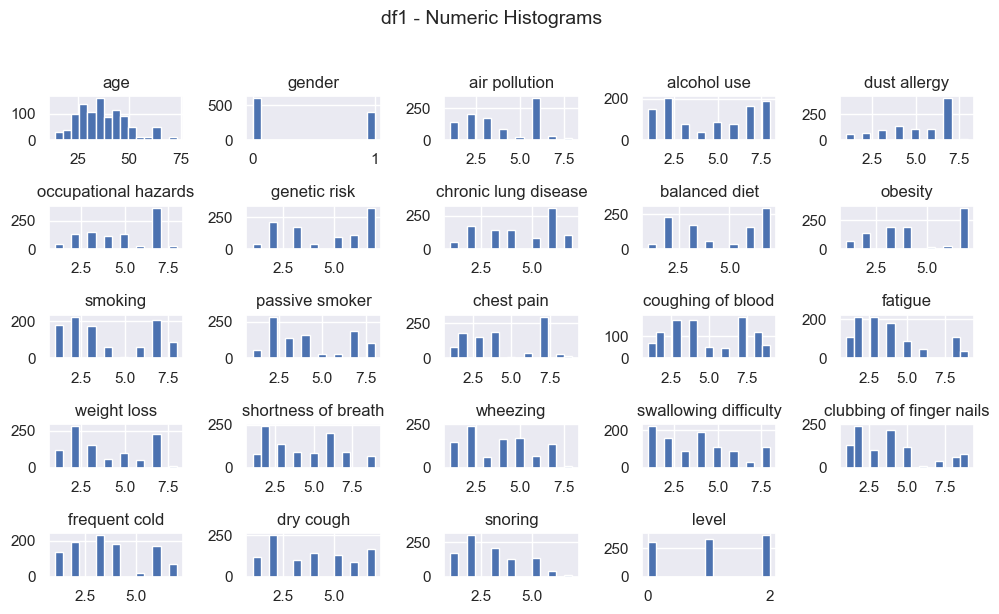

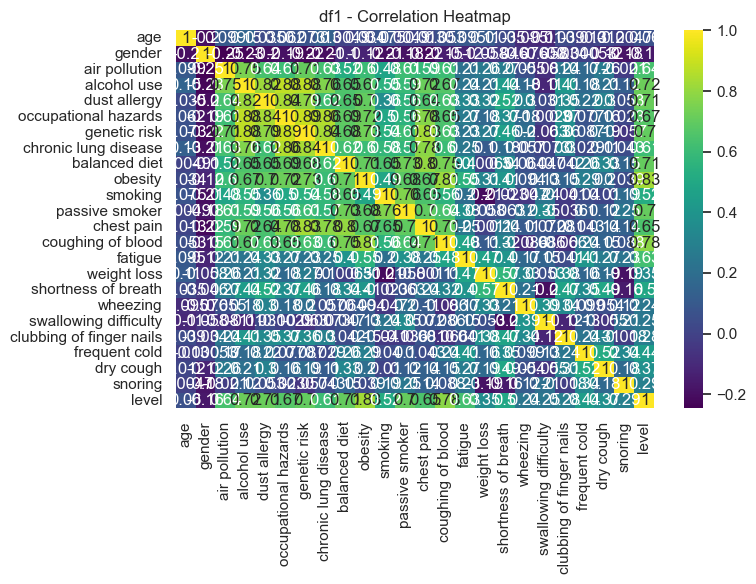

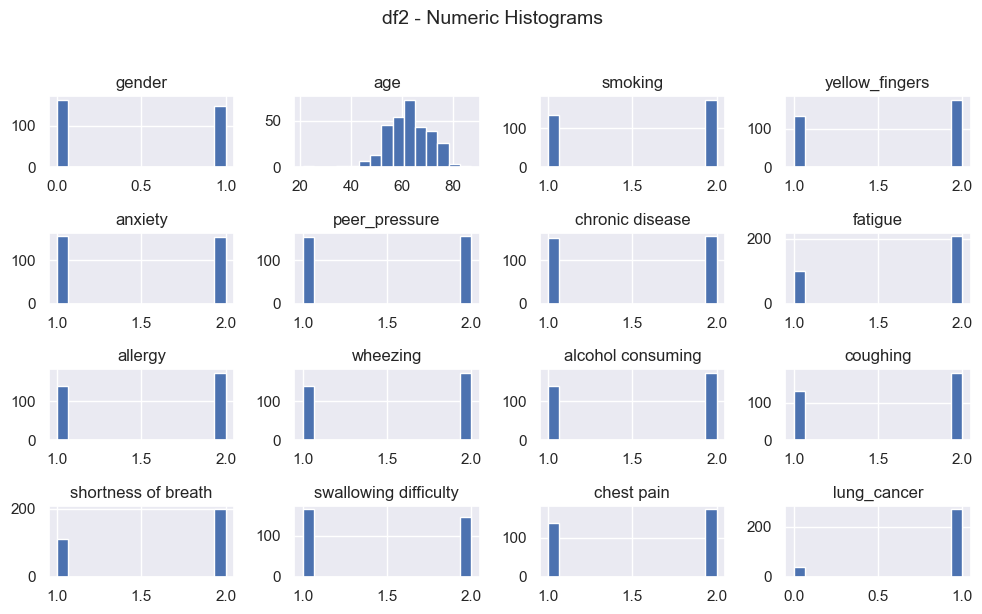

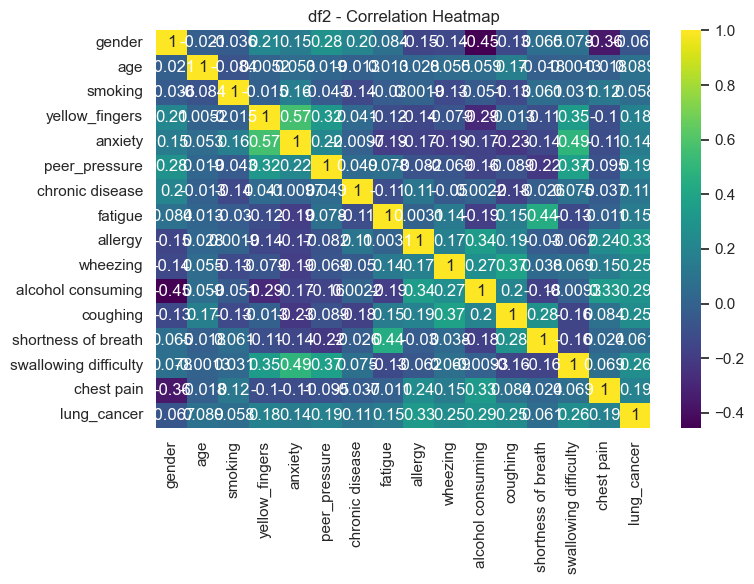

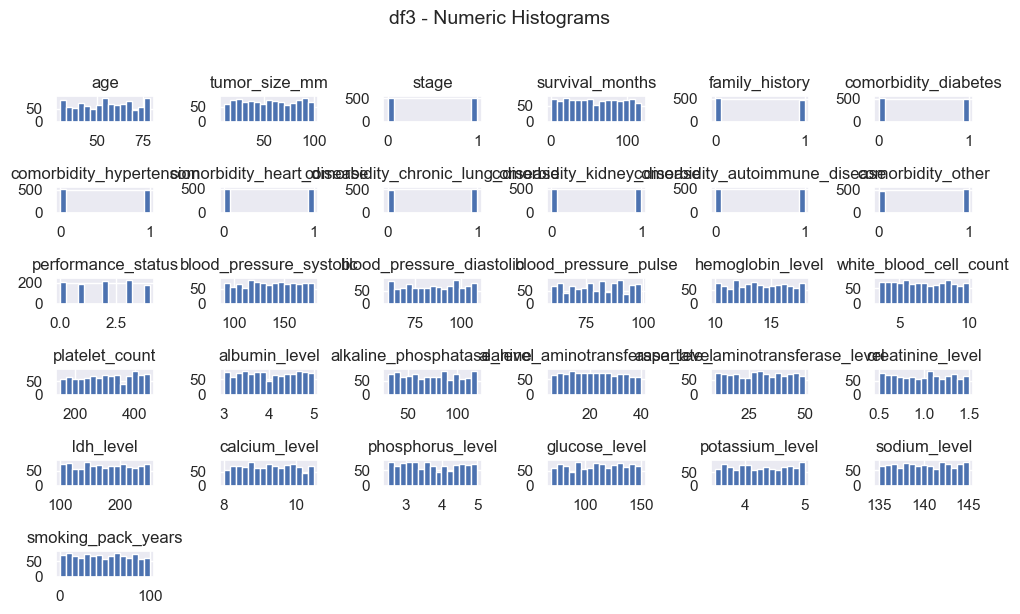

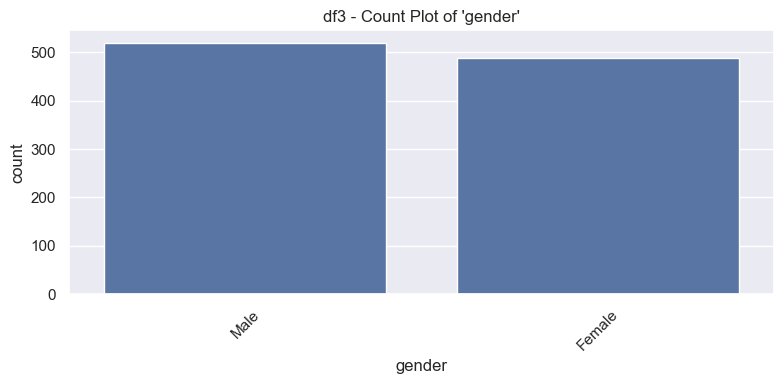

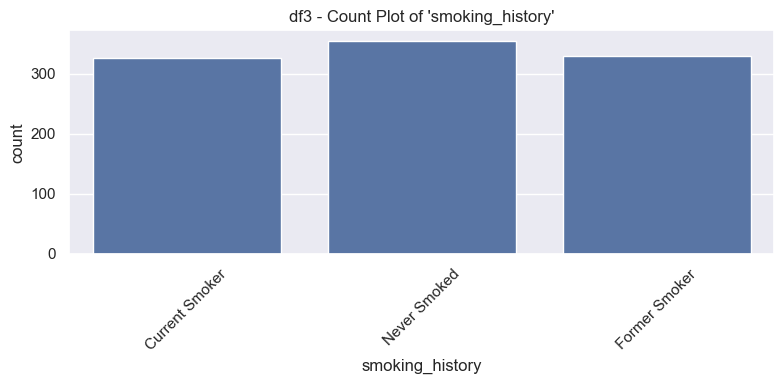

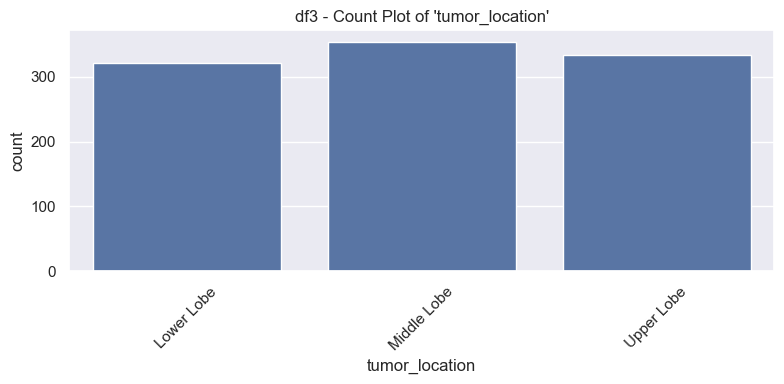

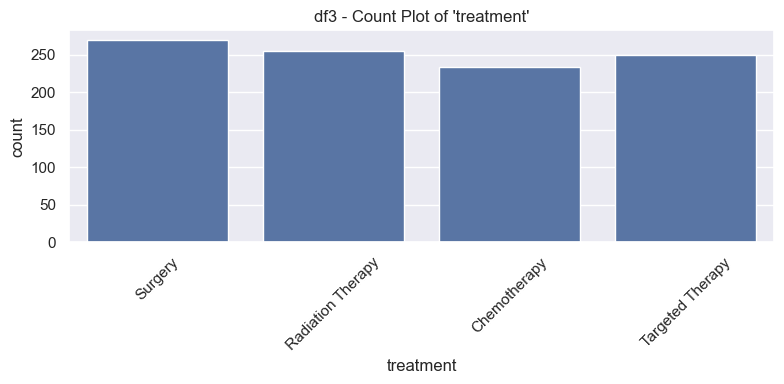

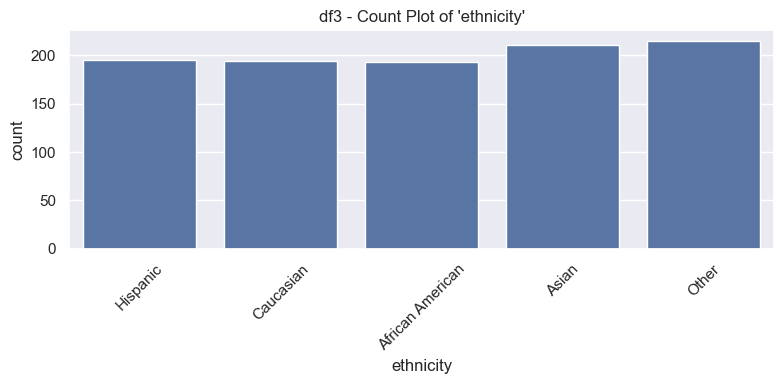

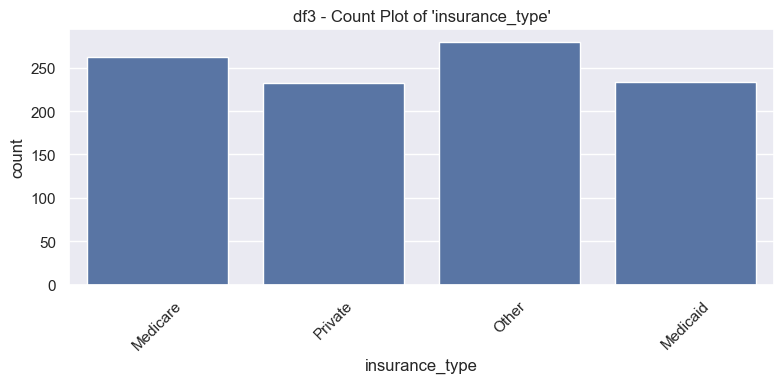

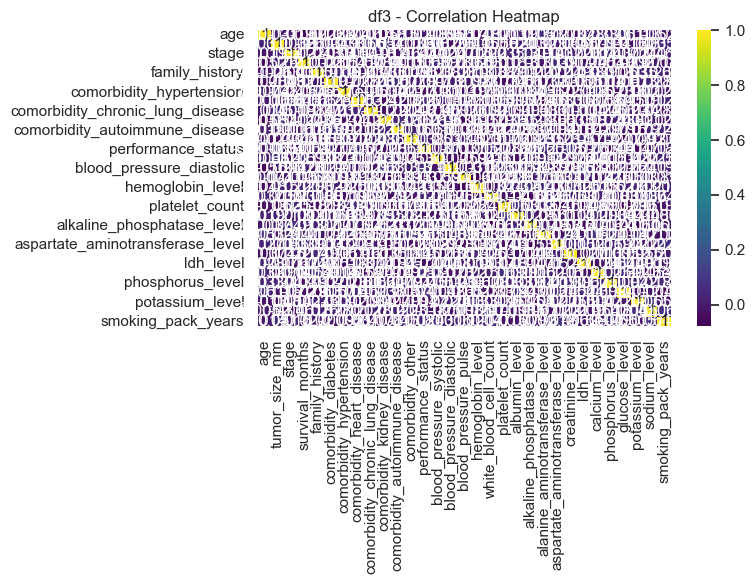

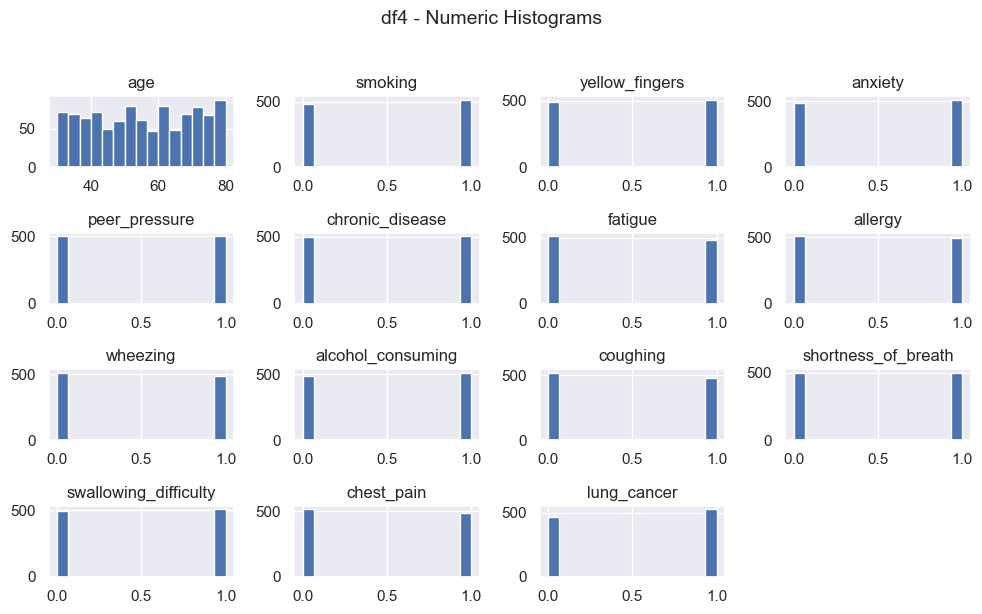

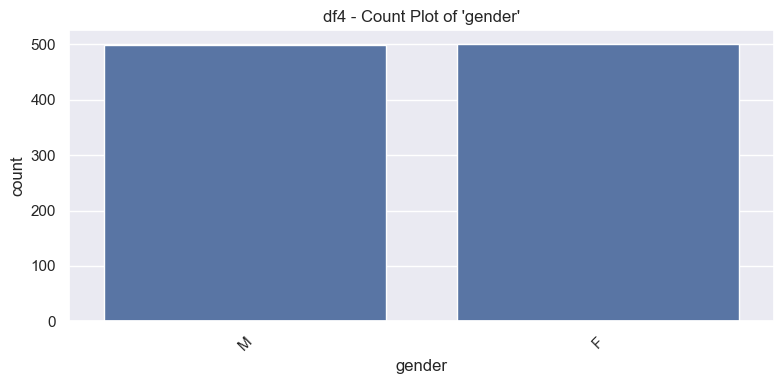

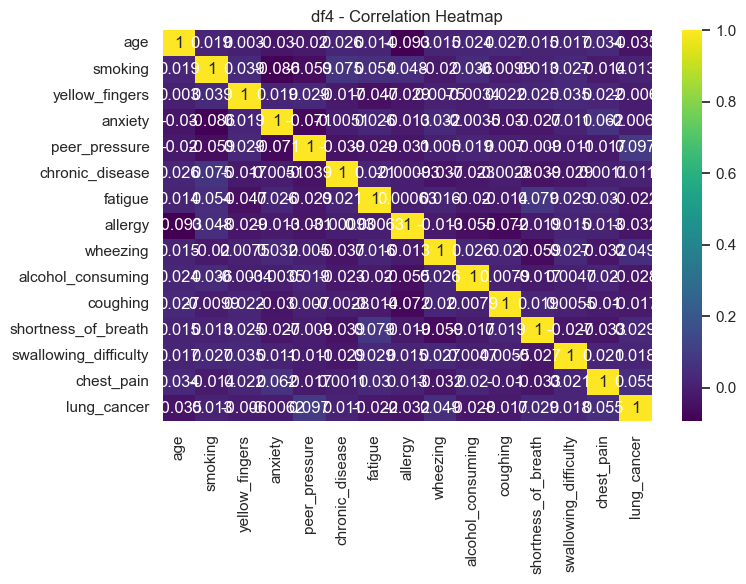

In [43]:
# Define a helper function to make EDA plots for a given dataframe
def visualize_data(df, name="DataFrame", max_cat_values=10):
    """
    Plots:
    1) Histograms for numeric columns
    2) Count plots for low-cardinality categorical columns
    3) Correlation heatmap for numeric columns
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if df.empty:
        print(f"{name} is empty, skipping visualization.")
        return
    
    # 1) Histograms for numeric columns
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns
    if len(numeric_cols) > 0:
        df[numeric_cols].hist(figsize=(10, 6), bins=15)
        plt.suptitle(f"{name} - Numeric Histograms", y=1.02, fontsize=14)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No numeric columns in {name} to plot histograms.")

    # 2) Count plots for 'low-cardinality' categoricals
    #    (i.e. columns with relatively few unique values)
    obj_cols = df.select_dtypes(include=['object']).columns
    for col in obj_cols:
        num_unique = df[col].nunique(dropna=True)
        if num_unique <= max_cat_values:
            plt.figure()
            sns.countplot(x=col, data=df)
            plt.title(f"{name} - Count Plot of '{col}'")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    # 3) Correlation heatmap for numeric columns
    if len(numeric_cols) > 1:
        corr_matrix = df[numeric_cols].corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='viridis')
        plt.title(f"{name} - Correlation Heatmap")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Not enough numeric columns in {name} for a correlation heatmap.")

# Now call the visualize_data function for each DataFrame
visualize_data(df1, name="df1")
visualize_data(df2, name="df2")
visualize_data(df3, name="df3")
visualize_data(df4, name="df4")


# 5) Pattern Mining & Visualization
We define a demonstration function `pattern_mining` that:
1. Uses `run_apriori` to get frequent itemsets from the dataframe.
2. Prints the **top 10** itemsets by support.
3. Plots a simple bar chart of the top 5 itemsets by support for visual inspection.


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from itertools import combinations

def pattern_mining(df, name="DF", severity_columns=None, min_support=0.20):
    """
    Runs FPGrowth on df (ignoring severity_columns if passed),
    prints top 10 frequent itemsets,
    plots bar chart for top 5 by support,
    returns the freq_items DataFrame for further usage.
    """
    if df.empty:
        print(f"Skipping Apriori for {name}, it's empty.")
        return pd.DataFrame()

    print(f"\n--- Pattern Mining on {name} (min_support={min_support}) ---")
    freq_items = run_apriori(
        df,
        ignore_cols=severity_columns if severity_columns else set(),
        min_support=min_support
    )
    if freq_items.empty:
        print("No frequent itemsets found.")
        return freq_items

    # Print the top 10 itemsets to get a sense of the discovered patterns
    print("Top itemsets:")
    print(freq_items.head(10))

    # Let's also visualize the top 5 itemsets in a bar chart
    top_n = 5 if freq_items.shape[0] >= 5 else freq_items.shape[0]
    top_items = freq_items.head(top_n).copy()
    # Convert frozenset -> string for plotting
    top_items['itemset_str'] = top_items['itemsets'].apply(lambda x: ','.join(list(x)))

    plt.figure()
    sns.barplot(data=top_items, x='support', y='itemset_str')
    plt.title(f"Top {top_n} itemsets by support ({name})")
    plt.xlabel("Support")
    plt.ylabel("Itemsets")
    plt.show()

    return freq_items


# 6) Create New Columns from Top Frequent Itemsets
Sometimes we want to enrich our dataset with features that indicate whether a row matches a particular frequent itemset. 
For the top K (by default: 5) itemsets (by support), we'll check if each row in the dataset "contains" that pattern and store a binary flag.


In [45]:
def create_association_features(df, freq_items, top_k=5, name="DF"):
    """
    Given freq_items from fpgrowth, create up to 'top_k' binary columns
    indicating whether each row 'contains' the itemset.
    """
    if freq_items.empty:
        print(f"{name}: No frequent itemsets to turn into features.")
        return df

    freq_items_sorted = freq_items.sort_values('support', ascending=False)
    top_itemsets = freq_items_sorted.head(top_k).copy()

    df_new = df.copy()

    for idx, row in top_itemsets.iterrows():
        itemset = row['itemsets']  # frozenset of strings
        sorted_conds = sorted(list(itemset))
        combined_name = "_AND_".join(sorted_conds).replace("=", "_EQ_")

        # Remove or replace any forbidden chars from the feature name
        forbidden_chars = ["[", "]", "<", ">", "(", ")", ":"]
        for ch in forbidden_chars:
            combined_name = combined_name.replace(ch, "_")

        feature_name = f"assoc_rule_{combined_name}"

        def check_row_contains_itemset(df_row):
            """
            Return 1 if row satisfies each condition in the itemset.
            E.g. 'col=val' => row[col] == val, else row does not contain that itemset.
            If the condition is just 'colName', we interpret it as colName==1.
            """
            for condition in itemset:
                if '=' in condition:
                    col, val = condition.split('=', 1)
                    if col not in df_row or str(df_row[col]) != val:
                        return 0
                else:
                    if condition not in df_row or df_row[condition] != 1:
                        return 0
            return 1

        # Create the binary column in df_new
        df_new[feature_name] = df_new.apply(check_row_contains_itemset, axis=1)
        print(f"Created association feature '{feature_name}' from itemset: {itemset}")

    return df_new


# 7) Numeric "Above Mean" Feature Engineering
Here, we show another way of extracting features from numeric columns by:
1. Identifying each numeric column (unless it's in `severity_columns`).
2. Creating a binary feature: `1` if a row is above the mean of that column, `0` otherwise.
This is a simple but sometimes effective technique for classification tasks.


In [46]:
def feature_engineering(df, severity_columns=None, name="DF"):
    """
    For each numeric column (excluding severity_columns),
    create a binary feature indicating if col > its mean.
    """
    if severity_columns is None:
        severity_columns = set()

    if df.empty:
        print(f"{name}: empty, skipping feature engineering.")
        return df

    df_new = df.copy()
    numeric_cols = df_new.select_dtypes(include=[np.number]).columns
    numeric_cols = [c for c in numeric_cols if c not in severity_columns]

    if len(numeric_cols) == 0:
        print(f"No numeric columns found in {name} to do feature engineering.")
        return df_new

    for col in numeric_cols:
        mean_val = df_new[col].mean(skipna=True)
        new_feat_name = col + "_above_mean"
        df_new[new_feat_name] = (df_new[col] > mean_val).astype(int)
        print(f"Created new feature '{new_feat_name}' in {name}, threshold={mean_val:.2f}")

    return df_new


## 8) Generate Pairwise Feature Combinations

By combining each pair of non-severity columns into a single new column (for instance, merging `"10"` and `"Yes"` into `"10_Yes"`), we can capture interactions that might be missed when examining columns independently.
This idea aligns with methods like FP-Growth and Apriori, which look for frequent itemsets by grouping items together; creating pairwise combinations helps reveal more nuanced associations within the data.


In [47]:
def create_combination_features(df, target_col, severity_columns=None, name="DF"):
    """
    For all columns except the target_col and severity_cols,
    create pairwise combos by string concatenation.
    This can produce many features, so be mindful of potential dimensionality.
    """
    if severity_columns is None:
        severity_columns = set()

    if df.empty:
        print(f"{name}: empty, skipping combination features.")
        return df

    df_new = df.copy()
    exclude = set(severity_columns) | {target_col}
    candidate_cols = [c for c in df_new.columns if c not in exclude]

    from itertools import combinations
    pairs = list(combinations(candidate_cols, 2))
    print(f"{name}: Creating combination features for {len(pairs)} pairs...")

    for (colA, colB) in pairs:
        new_col_name = f"{colA}__{colB}"
        # remove problematic chars
        for ch in ["[", "]", "<", ">", "(", ")", ":"]:
            new_col_name = new_col_name.replace(ch, "_")

        df_new[new_col_name] = df_new[colA].astype(str) + "_" + df_new[colB].astype(str)

    return df_new


# 9) Feature Selection with XGBoost
To reduce the feature space (which can get quite large), we use an **XGBoost regressor** to measure feature importance. The most important features are then returned for use in a final model:
1. We split the data into `X` and `y`, removing rows with missing target values.
2. We label-encode object columns, fill numeric `NaN`s with the median value of those respective columns, and scale the data.
3. The XGBoost model is trained, and feature importances are extracted.
4. We return the top N (5 by default) features with highest importance scores.


In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

def select_best_features(df, target_col, top_n=5, severity_columns=None):
    """
    1) Splits df into X and y (target).
    2) Uses XGBRegressor to measure feature importance.
    3) Returns top_n features by importance.
    """
    if df.empty or target_col not in df.columns:
        print(f"select_best_features: Invalid df or missing target_col='{target_col}'.")
        return []

    if severity_columns is None:
        severity_columns = set()

    df_model = df.dropna(subset=[target_col]).copy()
    y = df_model[target_col].values

    # Ensure the target is numeric, or try to convert it
    if not np.issubdtype(y.dtype, np.number):
        print(f"WARNING: target '{target_col}' is not numeric. Attempting to convert to numeric...")
        try:
            y = pd.to_numeric(y)
        except ValueError:
            print(f"ERROR: Could not convert target '{target_col}' to numeric. Aborting.")
            return []

    # Drop the target from X
    X = df_model.drop(columns=[target_col], axis=1)

    # Exclude severity columns from X
    drop_cols = list(severity_columns.intersection(X.columns))
    if drop_cols:
        X.drop(columns=drop_cols, inplace=True)

    # Label-encode any object columns
    obj_cols = X.select_dtypes(include=['object']).columns
    for col in obj_cols:
        le_x = LabelEncoder()
        X[col] = le_x.fit_transform(X[col].astype(str))

    # Fill numeric NaNs & scale
    X = X.fillna(X.median(numeric_only=True))
    num_cols = X.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])

    # Split data into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [1, 2, 3],
        'learning_rate': [1.0, 0.1, 0.01],
        'reg_alpha': [0, 10, 20],
        'reg_lambda': [0, 10, 20]
    }
    # Set up the XGBRegressor with default settings
    xgb_reg = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

    # Perform a grid search to find the best hyperparameters
    grid_search = GridSearchCV(
        estimator=xgb_reg,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',  # or another metric
        cv=5,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Extract feature importances from the best model
    importances = best_model.feature_importances_
    features = X.columns
    feat_imp_pairs = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)
    top_features = [f[0] for f in feat_imp_pairs[:top_n]]

    print("\nFeature importances (descending) from the best XGB model:")
    for feat, imp in feat_imp_pairs:
        print(f"  {feat}: {imp:.4f}")

    print(f"\nTop {len(top_features)} features (max {top_n}): {top_features}\n")
    return top_features


# 10) Final XGBoost Regression + Classification Metrics
Below is a utility function to:
1. Train an XGBRegressor on the selected columns.
2. Print regression metrics (**RMSE** and **R^2**).
3. Treat the output as if it's a "score" that can be thresholded to produce a binary classification. We pick `0.1` arbitrarily, then calculate accuracy and the usual classification report.


In [49]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

def run_xgboost_regression(df, target_col='some_numeric_target', dataset_name="Dataset"):
    """
    Trains an XGBRegressor on the given df, prints regression & classification metrics.
    Returns a dict with RMSE, R^2, accuracy, precision, recall, f1.
    """
    if df.empty:
        print(f"{dataset_name}: empty, skipping model training.")
        return None

    if target_col not in df.columns:
        print(f"{dataset_name}: no '{target_col}' column found, skipping model training.")
        return None

    # Drop rows where target is missing
    df_model = df.dropna(subset=[target_col]).copy()
    y = df_model[target_col]
    X = df_model.drop(columns=[target_col], axis=1)

    # Ensure the target is numeric
    if not np.issubdtype(y.dtype, np.number):
        print(f"WARNING: '{target_col}' is not numeric. Attempting to convert...")
        try:
            y = pd.to_numeric(y)
        except ValueError:
            print(f"ERROR: Could not convert '{target_col}' to numeric. Aborting.")
            return None

    # Encode categorical features in X
    obj_cols = X.select_dtypes(include=['object']).columns
    for col in obj_cols:
        le_x = LabelEncoder()
        X[col] = le_x.fit_transform(X[col].astype(str))

    # Fill NaNs and scale numeric columns
    X = X.fillna(X.median(numeric_only=True))
    num_cols = X.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # 1) Define a basic XGBRegressor with a consistent random_state
    xgb_reg = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

    # 2) Define a param grid for grid search
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [1, 2, 3],
        'learning_rate': [1.0, 0.1, 0.01],
        'reg_alpha': [0, 10, 20],
        'reg_lambda': [0, 10, 20]
    }

    # 3) Set up and run GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_reg,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',  # or 'neg_root_mean_squared_error'
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # 4) Retrieve the best model
    best_xgb = grid_search.best_estimator_

    print(f"\n--- {dataset_name} ---")
    print("Best Parameters:", grid_search.best_params_)

    # Predict using the best model
    y_pred = best_xgb.predict(X_test)

    # Regression metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE:  {rmse:.4f}")
    print(f"R^2:   {r2:.4f}")

    # Classification-like metrics (threshold=0.1)
    preds_bin = (y_pred >= 0.1).astype(int)
    acc = accuracy_score(y_test, preds_bin)
    cr_dict = classification_report(y_test, preds_bin, output_dict=True)
    weighted_avg = cr_dict.get('weighted avg', {})
    prec = weighted_avg.get('precision', 0.0)
    rec = weighted_avg.get('recall', 0.0)
    f1 = weighted_avg.get('f1-score', 0.0)

    print("\nClassification Metrics (threshold=0.1):")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds_bin))

    return {
        'RMSE': rmse,
        'R^2': r2,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }


# 11) Usage
Here is how we tie everything together step-by-step:
1. **Run Pattern Mining** on each dataset to discover frequent itemsets.
2. **Create new association features** from the top itemsets.
3. Perform **numeric feature engineering** (binary flags for above-mean).
4. **Pairwise combine** features.
5. **Feature selection** with XGBoost to find the top features.
6. **Run final XGBoost regression** (and classification metrics) using only the top features plus the target column.



--- Pattern Mining on df1 (min_support=0.25) ---
Top itemsets:
    support                           itemsets
0     0.691  (clubbing of finger nails_<=_4.0)
23    0.681                   (snoring_<=_3.0)
1     0.660     (swallowing difficulty_<=_4.0)
2     0.645            (passive smoker_<=_4.0)
3     0.612                 (dry cough_<=_4.0)
4     0.612                  (wheezing_<=_4.0)
5     0.605                (chest pain_<=_4.0)
6     0.598                    (gender_<=_0.0)
7     0.594                   (obesity_<=_4.0)
8     0.585              (dust allergy_<=_6.0)


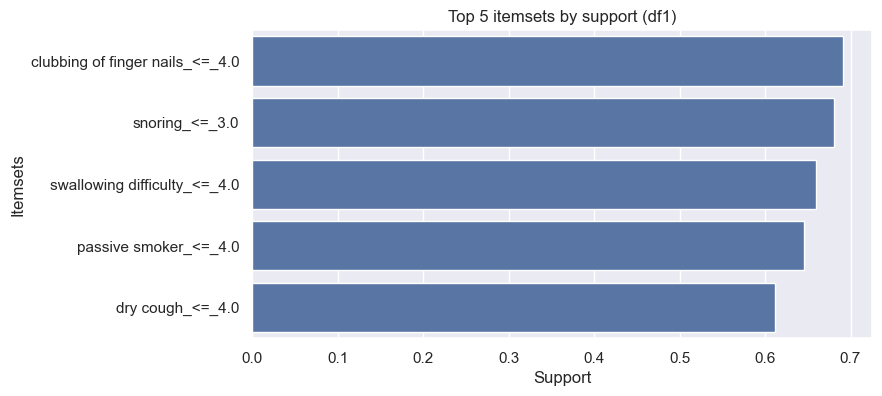


--- Pattern Mining on df2 (min_support=0.25) ---
Top itemsets:
      support                                           itemsets
0         1.0                                (chest pain_<=_2.0)
1413      1.0  (smoking_<=_2.0, chest pain_<=_2.0, yellow_fin...
1379      1.0  (smoking_<=_2.0, chest pain_<=_2.0, yellow_fin...
1378      1.0  (smoking_<=_2.0, yellow_fingers_<=_2.0, wheezi...
1377      1.0  (wheezing_<=_2.0, peer_pressure_<=_2.0, chest ...
1376      1.0  (smoking_<=_2.0, chest pain_<=_2.0, wheezing_<...
1375      1.0  (smoking_<=_2.0, wheezing_<=_2.0, peer_pressur...
1374      1.0  (chest pain_<=_2.0, wheezing_<=_2.0, yellow_fi...
1373      1.0  (yellow_fingers_<=_2.0, wheezing_<=_2.0, peer_...
1372      1.0  (smoking_<=_2.0, yellow_fingers_<=_2.0, wheezi...


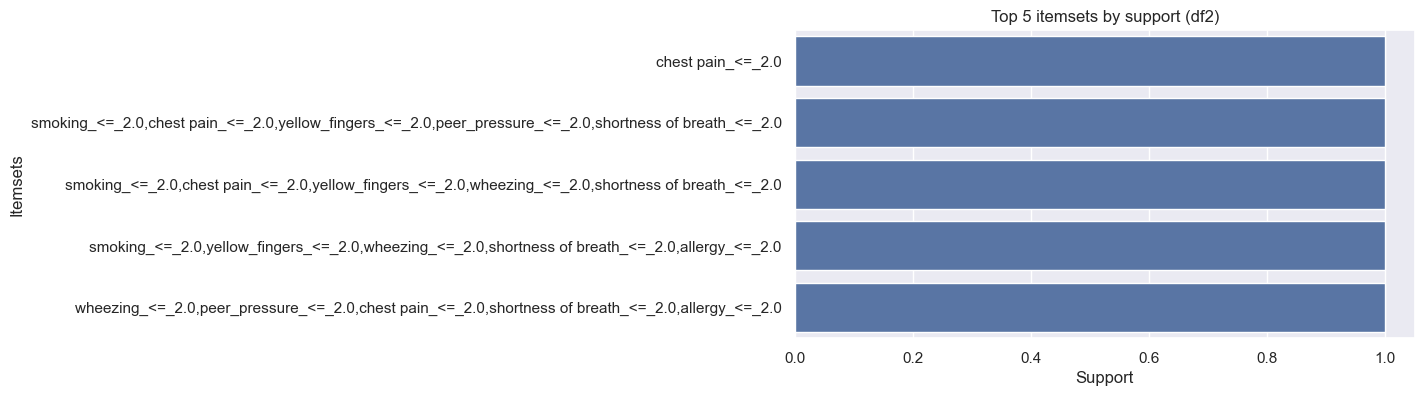


--- Pattern Mining on df3 (min_support=0.25) ---
Top itemsets:
       support                                           itemsets
0     1.000000          (comorbidity_chronic_lung_disease_<=_1.0)
1     1.000000                         (comorbidity_other_<=_1.0)
70    1.000000  (comorbidity_other_<=_1.0, comorbidity_chronic...
2697  0.599206  (performance_status_<=_2.0, comorbidity_other_...
2698  0.599206  (performance_status_<=_2.0, comorbidity_chroni...
2699  0.599206  (performance_status_<=_2.0, comorbidity_other_...
48    0.599206                        (performance_status_<=_2.0)
74    0.523810  (family_history_<=_0.0, comorbidity_other_<=_1...
2     0.523810                            (family_history_<=_0.0)
71    0.523810  (family_history_<=_0.0, comorbidity_other_<=_1.0)


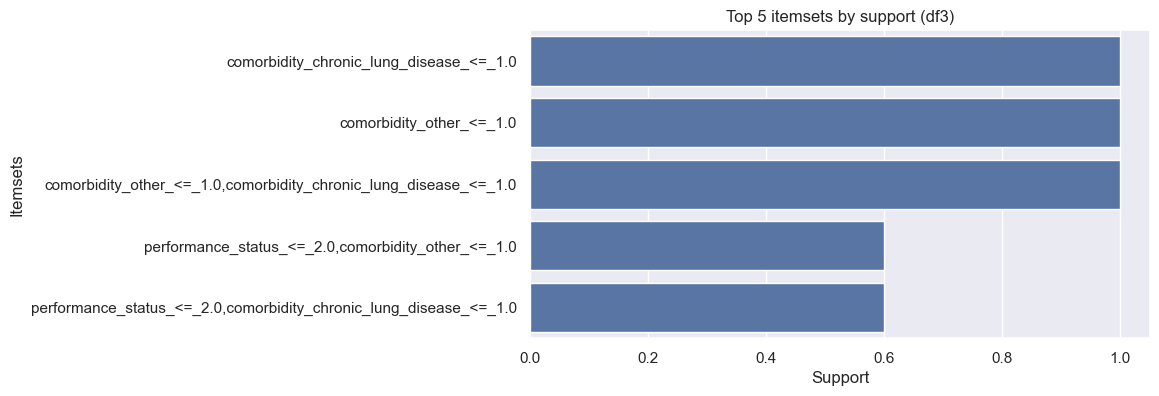


--- Pattern Mining on df4 (min_support=0.25) ---
Top itemsets:
    support                                           itemsets
0       1.0                                   (smoking_<=_1.0)
41      1.0  (alcohol_consuming_<=_1.0, smoking_<=_1.0, anx...
60      1.0  (alcohol_consuming_<=_1.0, chronic_disease_<=_...
59      1.0  (alcohol_consuming_<=_1.0, yellow_fingers_<=_1...
58      1.0  (anxiety_<=_1.0, smoking_<=_1.0, chronic_disea...
57      1.0  (anxiety_<=_1.0, chronic_disease_<=_1.0, swall...
56      1.0  (anxiety_<=_1.0, yellow_fingers_<=_1.0, chroni...
55      1.0  (alcohol_consuming_<=_1.0, chronic_disease_<=_...
54      1.0           (smoking_<=_1.0, chronic_disease_<=_1.0)
53      1.0  (chronic_disease_<=_1.0, swallowing_difficulty...


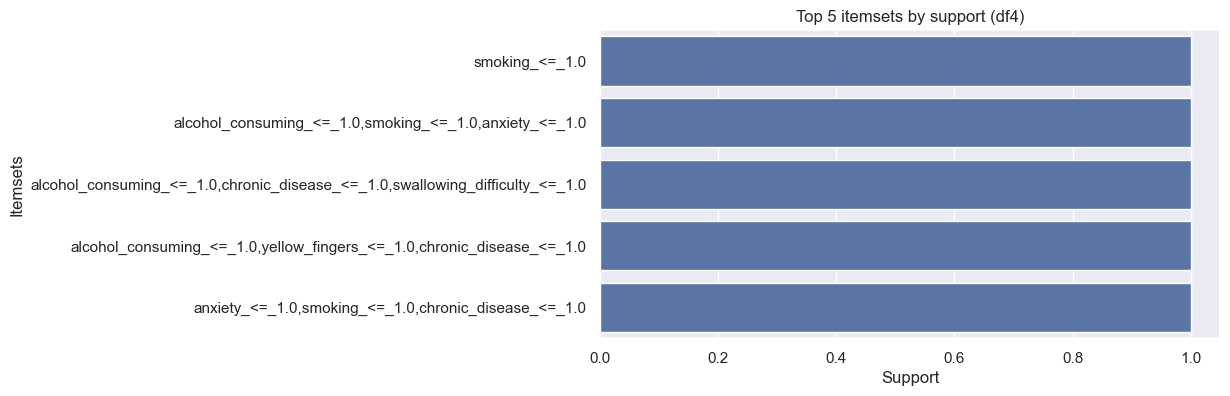

df1: Created feature 'assoc_rule_clubbing of finger nails___EQ__4.0' from itemset=frozenset({'clubbing of finger nails_<=_4.0'})
df1: Created feature 'assoc_rule_snoring___EQ__3.0' from itemset=frozenset({'snoring_<=_3.0'})
df1: Created feature 'assoc_rule_swallowing difficulty___EQ__4.0' from itemset=frozenset({'swallowing difficulty_<=_4.0'})
df1: Created feature 'assoc_rule_passive smoker___EQ__4.0' from itemset=frozenset({'passive smoker_<=_4.0'})
df1: Created feature 'assoc_rule_dry cough___EQ__4.0' from itemset=frozenset({'dry cough_<=_4.0'})
df2: Created feature 'assoc_rule_chest pain___EQ__2.0' from itemset=frozenset({'chest pain_<=_2.0'})
df2: Created feature 'assoc_rule_alcohol consuming___EQ__2.0_AND_chronic disease___EQ__2.0_AND_coughing___EQ__2.0_AND_fatigue___EQ__2.0_AND_shortness of breath___EQ__2.0_AND_smoking___EQ__2.0_AND_yellow_fingers___EQ__2.0' from itemset=frozenset({'smoking_<=_2.0', 'chronic disease_<=_2.0', 'fatigue_<=_2.0', 'alcohol consuming_<=_2.0', 'yellow_

In [50]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from mlxtend.frequent_patterns import association_rules

#########################
# SANITIZE FUNCTION
#########################
import re
def sanitize_feature_name(name):
    """
    Replace forbidden chars [ ] < > with underscores.
    """
    return re.sub(r'[\[\]<>]', '_', name)


# 1) Pattern Mining (with min_support=0.25)
freq_df1 = pattern_mining(df1, name="df1", severity_columns={"level"}, min_support=0.25)
freq_df2 = pattern_mining(df2, name="df2", severity_columns={"lung_cancer"}, min_support=0.25)
freq_df3 = pattern_mining(df3, name="df3", severity_columns={"stage"}, min_support=0.25)
freq_df4 = pattern_mining(df4, name="df4", severity_columns={"lung_cancer"}, min_support=0.25)

# 1B) Association Rules after frequent itemsets
def get_top_rules(freq_items, min_conf=0.6, min_lift=1.0, top_k=5):
    """
    Given a DataFrame of frequent itemsets, compute association rules,
    filter by min_conf, min_lift, then return top_k by confidence.
    """
    if freq_items.empty:
        return pd.DataFrame()
    rules = association_rules(freq_items, metric="confidence", min_threshold=min_conf)
    # Filter by lift
    rules = rules[rules['lift'] >= min_lift]
    # Sort by confidence desc
    rules = rules.sort_values('confidence', ascending=False)
    # Take top_k
    return rules.head(top_k)


rules_df1 = get_top_rules(freq_df1, min_conf=0.6, min_lift=1.0, top_k=5)
rules_df2 = get_top_rules(freq_df2, min_conf=0.6, min_lift=1.0, top_k=5)
rules_df3 = get_top_rules(freq_df3, min_conf=0.6, min_lift=1.0, top_k=5)
rules_df4 = get_top_rules(freq_df4, min_conf=0.6, min_lift=1.0, top_k=5)


# 2) Create new columns from top frequent itemsets
def create_association_features(df, freq_items, top_k=5, name="DF"):
    """
    Convert top_k itemsets (by support) into new binary columns
    indicating whether a row meets all conditions in the itemset.
    """
    if freq_items.empty:
        print(f"{name}: No frequent itemsets to create features from.")
        return df

    freq_items_sorted = freq_items.sort_values('support', ascending=False)
    top_itemsets = freq_items_sorted.head(top_k).copy()

    df_new = df.copy()

    def row_contains_itemset(row, itemset):
        """Return 1 if row meets every condition 'col=val' or 'colName' in the itemset."""
        for cond in itemset:
            if '=' in cond:
                col, val = cond.split('=', 1)
                if str(row.get(col, None)) != val:
                    return 0
            else:
                # If item is just a column name or numeric threshold
                # Then we expect row[cond] == 1
                if row.get(cond, 0) != 1:
                    return 0
        return 1

    for idx, freq_row in top_itemsets.iterrows():
        itemset = freq_row['itemsets']  # frozenset
        sorted_conds = sorted(list(itemset))

        # Build base name safely
        combined_name = "_AND_".join(cond.replace("=", "_EQ_") for cond in sorted_conds)
        combined_name = sanitize_feature_name(combined_name)  # remove any brackets, etc.
        feature_name = sanitize_feature_name(f"assoc_rule_{combined_name}")

        df_new[feature_name] = df_new.apply(lambda r: row_contains_itemset(r, itemset), axis=1)
        print(f"{name}: Created feature '{feature_name}' from itemset={itemset}")

    return df_new


df1_assoc = create_association_features(df1, freq_df1, top_k=5, name="df1")
df2_assoc = create_association_features(df2, freq_df2, top_k=5, name="df2")
df3_assoc = create_association_features(df3, freq_df3, top_k=5, name="df3")
df4_assoc = create_association_features(df4, freq_df4, top_k=5, name="df4")


# 2B) Create new columns from top association rules (antecedents).
def create_rule_features(df, rules_df, name="DF"):
    """
    Create binary columns in df indicating whether each row 'contains'
    the antecedent of each rule in rules_df.
    The 'antecedent' is a frozenset of conditions like 'col=val'.
    We'll name the new column 'rule_<ruleIndex>_<antecedentStr>'.
    """
    if rules_df.empty:
        print(f"{name}: No association rules found to create rule-based features.")
        return df

    df_new = df.copy()
    for i, row in rules_df.iterrows():
        antecedent = row['antecedents']  # a frozenset
        # Build a feature name from these antecedent items
        sorted_conds = sorted(list(antecedent))
        cond_str = "_AND_".join(cond.replace("=", "_EQ_") for cond in sorted_conds)
        cond_str = sanitize_feature_name(cond_str)   # remove [ ] < >
        feature_name = sanitize_feature_name(f"rule_{i}_{cond_str}")

        # check if row satisfies all conditions in the antecedent
        def check_row_contains_antecedent(r):
            for cond in antecedent:
                if "=" in cond:
                    col, val = cond.split("=", 1)
                    if col not in r or str(r[col]) != val:
                        return 0
                else:
                    # If your item is just a column name "something",
                    # then we require r[something] == 1
                    if cond not in r or r[cond] != 1:
                        return 0
            return 1

        df_new[feature_name] = df_new.apply(check_row_contains_antecedent, axis=1)
        print(f"{name}: Created rule feature '{feature_name}' from antecedent={antecedent}")

    return df_new


df1_rules_assoc = create_rule_features(df1_assoc, rules_df1, name="df1")
df2_rules_assoc = create_rule_features(df2_assoc, rules_df2, name="df2")
df3_rules_assoc = create_rule_features(df3_assoc, rules_df3, name="df3")
df4_rules_assoc = create_rule_features(df4_assoc, rules_df4, name="df4")


# 3) Numeric "above mean" engineering
df1_fe = feature_engineering(df1_rules_assoc, severity_columns={"level"}, name="df1")
df2_fe = feature_engineering(df2_rules_assoc, severity_columns={"lung_cancer"}, name="df2")
df3_fe = feature_engineering(df3_rules_assoc, severity_columns={"stage"}, name="df3")
df4_fe = feature_engineering(df4_rules_assoc, severity_columns={"lung_cancer"}, name="df4")


# 4) Create additional combined features (pairwise combos)
df1_combined = create_combination_features(df1_fe, target_col="level",
                                           severity_columns={"level"},
                                           name="df1")
df2_combined = create_combination_features(df2_fe, target_col="lung_cancer",
                                           severity_columns={"lung_cancer"},
                                           name="df2")
df3_combined = create_combination_features(df3_fe, target_col="stage",
                                           severity_columns={"stage"},
                                           name="df3")
df4_combined = create_combination_features(df4_fe, target_col="lung_cancer",
                                           severity_columns={"lung_cancer"},
                                           name="df4")


# 5) Select top 5 features from each dataset
best_features_df1 = select_best_features(df1_combined, target_col="level", top_n=5,
                                         severity_columns={"level"})
best_features_df2 = select_best_features(df2_combined, target_col="lung_cancer", top_n=5,
                                         severity_columns={"lung_cancer"})
best_features_df3 = select_best_features(df3_combined, target_col="stage", top_n=5,
                                         severity_columns={"stage"})
best_features_df4 = select_best_features(df4_combined, target_col="lung_cancer", top_n=5,
                                         severity_columns={"lung_cancer"})


# 6) Final XGBoost regression/classification
print("\n===== FINAL XGBREGRESSOR TRAINING & EVALUATION =====")

# Evaluate df1 if we have any top features
results1 = None
if len(best_features_df1) > 0:
    subset_cols = best_features_df1 + ["level"]
    results1 = run_xgboost_regression(df1_combined[subset_cols],
                                      target_col="level",
                                      dataset_name="df1_combined_top5")
    print("\nDF1 Results:", results1)
else:
    print("No top features found for df1; skipping final model.")

# Evaluate df2 if we have any top features
results2 = None
if len(best_features_df2) > 0:
    subset_cols = best_features_df2 + ["lung_cancer"]
    results2 = run_xgboost_regression(df2_combined[subset_cols],
                                      target_col="lung_cancer",
                                      dataset_name="df2_combined_top5")
    print("\nDF2 Results:", results2)
else:
    print("No top features found for df2; skipping final model.")

# Evaluate df3
results3 = None
if len(best_features_df3) > 0:
    subset_cols = best_features_df3 + ["stage"]
    results3 = run_xgboost_regression(df3_combined[subset_cols],
                                      target_col="stage",
                                      dataset_name="df3_combined_top5")
    print("\nDF3 Results:", results3)
else:
    print("No top features found for df3; skipping final model.")

# Evaluate df4
results4 = None
if len(best_features_df4) > 0:
    subset_cols = best_features_df4 + ["lung_cancer"]
    results4 = run_xgboost_regression(df4_combined[subset_cols],
                                      target_col="lung_cancer",
                                      dataset_name="df4_combined_top5")
    print("\nDF4 Results:", results4)
else:
    print("No top features found for df4; skipping final model.")


# Summarize the accuracy metrics for each dataset
if results1 is not None:
    print(f"DF1 Accuracy: {results1['accuracy']:.3f}")

if results2 is not None:
    print(f"DF2 Accuracy: {results2['accuracy']:.3f}")

if results3 is not None:
    print(f"DF3 Accuracy: {results3['accuracy']:.3f}")

if results4 is not None:
    print(f"DF4 Accuracy: {results4['accuracy']:.3f}")


# Additional Classification (Baseline)
Below, we demonstrate how to do quick classification with XGBRegressor (a baseline mode), using a threshold approach:
1. **Drop rows** with missing target.
2. If the target is numeric, binarize it around the median (or check if it's already 0/1).
3. If the target is categorical (non-numeric), we label-encode it.
4. Ensure there's at least 2 classes in the target.
5. Split, scale, and fit an XGBRegressor, then threshold predictions at 0.1 to compute classification metrics.


In [51]:
def run_classification(df, target_col, name="DF"):
    from xgboost import XGBRegressor
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, classification_report
    import pandas as pd
    import numpy as np

    if df.empty:
        print(f"{name}: empty, skipping classification.")
        return None
    if target_col not in df.columns:
        print(f"{name}: '{target_col}' not found, skipping classification.")
        return None

    print(f"\n--- Classification on {name}, Target={target_col} ---")

    # 1) Drop rows where target_col is missing
    dtemp = df.dropna(subset=[target_col]).copy()

    # 2) Binarize the target or label-encode if categorical
    if pd.api.types.is_numeric_dtype(dtemp[target_col]):
        # If it's already strictly 0/1, keep as is:
        unique_vals = dtemp[target_col].unique()
        if set(unique_vals).issubset({0, 1}):
            print(f"{name}: Target is already 0/1, using it as-is.")
            dtemp["_target_"] = dtemp[target_col]
        else:
            # Otherwise, binarize around the median
            median_val = dtemp[target_col].median()
            dtemp["_target_"] = (dtemp[target_col] > median_val).astype(int)
            print(f"{name}: numeric target => median={median_val:.2f}")
    else:
        # If the target is categorical, label-encode it
        print(f"{name}: categorical target => label-encode")
        le = LabelEncoder()
        dtemp["_target_"] = le.fit_transform(dtemp[target_col].astype(str))

    # 3) Ensure we have at least 2 classes
    if dtemp["_target_"].nunique() < 2:
        print(f"{name}: Only one class in target => trivial accuracy. Skipping.")
        return None

    # 4) Drop the original target column
    if target_col in dtemp.columns:
        dtemp.drop(columns=[target_col], inplace=True)


    # 5) Separate features from target
    X = dtemp.drop(columns=["_target_"], errors='ignore')
    y = dtemp["_target_"].values

    # 6) Encode categorical features in X
    obj_cols = X.select_dtypes(include=["object", "category"]).columns
    for col in obj_cols:
        le2 = LabelEncoder()
        X[col] = le2.fit_transform(X[col].astype(str))

    # 7) Fill numeric NaNs
    X = X.fillna(X.median(numeric_only=True))

    # 8) If no features remain, stop
    if X.shape[1] < 1:
        print(f"No usable features after cleaning in {name}.")
        return None

    # 9) Train-test split with stratify
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    print(f"{name}: y_train distribution: {np.bincount(y_train)}")
    print(f"{name}: y_test  distribution: {np.bincount(y_test)}")

    # 10) Scale numeric features
    sc = StandardScaler()
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)

    # 11) Fit an XGBRegressor
    regr = XGBRegressor(
        n_estimators=10,
        max_depth=1,
        learning_rate=0.1,
        reg_alpha=1,
        reg_lambda=10,
        eval_metric='rmse',
        random_state=42
    )
    regr.fit(X_train_scaled, y_train)

    # 12) Predict & threshold
    preds_continuous = regr.predict(X_test_scaled)
    preds = (preds_continuous >= 0.1).astype(int)

    # 13) Metrics
    acc = accuracy_score(y_test, preds)
    cr_dict = classification_report(y_test, preds, output_dict=True)
    print(f"{name} Accuracy: {acc:.3f}")
    print("Classification Report:")
    print(classification_report(y_test, preds))

    weighted_avg = cr_dict.get('weighted avg', {})
    return {
        'accuracy': acc,
        'precision': weighted_avg.get('precision'),
        'recall': weighted_avg.get('recall'),
        'f1': weighted_avg.get('f1-score')
    }

metrics_df = []

# If df1 has "level" as the target
m1 = run_classification(df1, target_col="level", name="df1")
if m1:
    m1['dataset'] = 'df1'
    metrics_df.append(m1)

# If df2 has "lung_cancer" as the target
m2 = run_classification(df2, target_col="lung_cancer", name="df2")
if m2:
    m2['dataset'] = 'df2'
    metrics_df.append(m2)

# If df3 has "stage" as the target
m3 = run_classification(df3, target_col="stage", name="df3")
if m3:
    m3['dataset'] = 'df3'
    metrics_df.append(m3)

# If df4 also uses "lung_cancer" as the target
m4 = run_classification(df4, target_col="lung_cancer", name="df4")
if m4:
    m4['dataset'] = 'df4'
    metrics_df.append(m4)

print("\nClassification Results:")
for row in metrics_df:
    print(row)



--- Classification on df1, Target=level ---
df1: numeric target => median=1.00
df1: y_train distribution: [444 256]
df1: y_test  distribution: [191 109]
df1 Accuracy: 0.363
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       191
           1       0.36      1.00      0.53       109

    accuracy                           0.36       300
   macro avg       0.18      0.50      0.27       300
weighted avg       0.13      0.36      0.19       300


--- Classification on df2, Target=lung_cancer ---
df2: Target is already 0/1, using it as-is.
df2: y_train distribution: [ 27 189]
df2: y_test  distribution: [12 81]
df2 Accuracy: 0.871
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.87      1.00      0.93        81

    accuracy                           0.87        93
   macro avg       0.44      0.50      0.47     

# Model Comparison

We trained two versions of our classification model on each dataset:

1. **Baseline Model**: No advanced feature engineering or pattern mining.
2. **Enhanced Model**: Includes pattern-mining-based features, numeric transformations, etc.

Below, we compare **accuracy** for each dataset:

| **Dataset** | **Baseline Accuracy** | **Enhanced Accuracy** |
|:----------:|:---------------------:|:---------------------:|
| **DF1**     |        0.3633         |         0.603         |
| **DF2**     |        0.8710         |        0.9250         |
| **DF3**     |         0.504         |         0.528         |
| **DF4**     |        0.5300         |        0.5270         |
